## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [2]:
# pandas and numpy

import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# model preparation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#import file 
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (946791, 16)


In [5]:
#subset the data
## chose 1% of tweets because full data set was computationally expensive 
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [6]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [7]:
#text data
congress_tweets['text'].head(15)

0     All of #OH14 salutes you, Patrolman St. Clair!...
1     In Case You Missed It: Bipartisanship works – ...
2     Wishing a happy #Passover to all those celebra...
3     RT @WhiteHouse President @realDonaldTrump just...
4     I just sent a letter demanding the Administrat...
5     The President’s attacks on Rep. @Ilhan are dis...
6     RT @HouseGOP It's time to get serious about ho...
7     RT @wdtnews With five confirmed COVID-19 cases...
8     RT @SVLeadershipGrp "We can only be game chang...
9     “This nation will remain the land of the free ...
10    This is true and we will address this soon.......
11    Preach. 🙏🏾 https://twitter.com/shondarhimes/st...
12    Among public institutions, @ASU is third in th...
13    There is no way Eric Swalwell should continue ...
14    NOW: on the air with @SethLeibsohn to talk abo...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [8]:
#replace all two independents as democrats 
congress_tweets['party']=congress_tweets['party'].replace(r"Independent", "Democrat", regex=True)

In [9]:
#Remove emojis
def rem_emoji(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [10]:
#Remove line breaks 
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#passing line function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [11]:
#Remove urls
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#passing urls function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [12]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") 
    nlp.Defaults.stop_words.add("qt") 
    nlp.Defaults.stop_words.add("amp") 
    nlp.Defaults.stop_words.add("need") # to get rid of the word "need" because it is large on all wordclouds
    nlp.Defaults.stop_words.add("today") # to get rid of the word "today" because it is large on all wordclouds
    nlp.Defaults.stop_words.add("thank") # to get rid of the word "thank" because it is large on all wordclouds
    
    punc = set(punctuation)
    punc.update(['–','“',"‘",'¯','1⃣']) # add additional symbols
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #to make the text all lower case 

    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [13]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values

In [14]:
# apply rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, , bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [15]:
#Remove blank spaces
def rem_spaces(text):
    text = [item.strip(' ') for item in text]  #removes white spaces in each item
    return [item for item in text if item]  #removes items that are empty strings

#Passing function to 'tokens'
congress_tweets['tokens'] = congress_tweets['tokens'].apply(rem_spaces)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [16]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9432, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [17]:
congress_tweets['tokens'][0] # text string -> tokens in list form -- no spaces, emojis, urls, or other punctuation

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 'rooseveltlfox8']

In [18]:
#check the length of smallest tweet
congress_tweets['tokens'].str.len().min()

1

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

In [19]:
# initialize wordcloud data and function

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

In [20]:
# create a dictionary of word frequencies

text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

## We are keeping these high frequency words because the frequency is different across parties and positions.

[('american', 619), ('work', 555), ('new', 548), ('help', 526), ('time', 525)]
[('american', 1.0), ('work', 0.8966074313408724), ('new', 0.8852988691437803), ('help', 0.8497576736672051), ('time', 0.8481421647819063)]


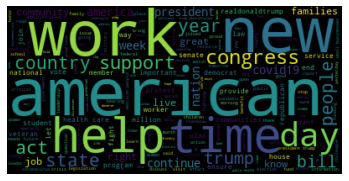

In [21]:
# plot WordCloud(ALL)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [22]:
#Table - political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (3409, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ..."
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson..."
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ..."


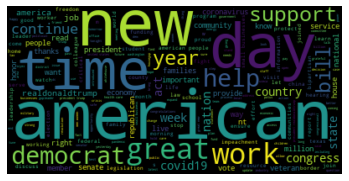

In [23]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
#Table - political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (6023, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da..."
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp..."


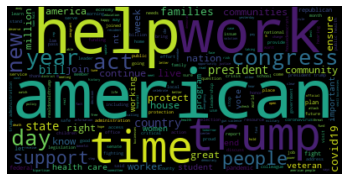

In [25]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [26]:
#Table - Legislator position-Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2239, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f..."
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ..."
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed..."
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre..."
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas..."


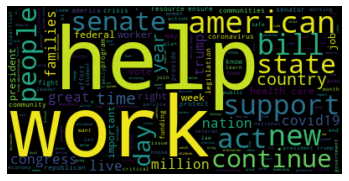

In [27]:
##WordCloud for Senators
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [28]:
#Table - Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7193, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


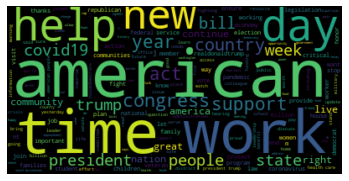

In [29]:
##WordCloud for House of Representatives
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Based on our word clouds, it appears that Republicans have a high frequency of the word “great” which makes sense given that Trump’s campaign was based on “Make America Great Again”. As for Democrats, it was interesting to find that the word “Trump” had a high frequency, which could be because they were concerned by his policies. When comparing senators and representatives, we find that senators have a high frequency of the word “help” and lower frequency of the word “american” compared to representatives. We are unsure of why this distinction exists although we find it is interesting to note.


## EDA 2. Topic modeling 

In [30]:
# add column where tokens are concatenated into a single string
congress_tweets['tokens_str'] = congress_tweets['tokens'].str.join(" ")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",oh14 salutes patrolman st clair fox8news 5year...
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",case missed bipartisanship works bill eradicat...
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",wishing happy passover celebrating seder tonight
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",whitehouse president realdonaldtrump signed bi...
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",sent letter demanding administration stop play...


In [31]:
#create tf-idf matrix
X = congress_tweets['tokens_str']
tf = TfidfVectorizer() #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0's

In [32]:
tfidf_matrix

<9432x27673 sparse matrix of type '<class 'numpy.float64'>'
	with 173245 stored elements in Compressed Sparse Row format>

In [33]:
dense_matrix

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
#initialize model/ prespecify the parameter n => "10 topics"
lda = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [35]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [36]:
#prints out top words using different objects attached to our lda model
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
de mental la final yes blacklivesmatter guy activities heading cancer launched beat commonwealth fireworks difficult applaud en mentor engaged ks02

Topic #1:
file payments irsnews irs payment tough covidreliefirs affected hit attn hardest deposit 26 commend beneficiaries conscience session leverage tried scams

Topic #2:
barrett ballot de amy coney el en necessary art competition la los drop loans oil suppression mental hawley para box

Topic #3:
justiceinpolicing hr8 articles hong sides aisle kong dosomething endgunviolence cummings elijah condition heres repjohnlewis pregnant wishing overwhelming happynewyear repthompson obstruction

Topic #4:
wishing happy responders confirmation easter christmas col family 1st afford de fourth merry jewish happythanksgiving johnson fy21ndaa lt neverforget independenceday

Topic #5:
payments loans saturday nancy filing idaho crime firefighters schumer borrowers difficult funded lender bank huawei colleges card finish contamination shorta

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.02145624, 0.02145586, 0.02145658, ..., 0.02145562, 0.18388844,
        0.02145718],
       [0.02553445, 0.02553445, 0.02553445, ..., 0.02553445, 0.66977402,
        0.02553456],
       [0.02956191, 0.02956191, 0.02956341, ..., 0.51978824, 0.02963536,
        0.02956668],
       ...,
       [0.01456925, 0.0145703 , 0.01457221, ..., 0.01457249, 0.40943278,
        0.01457471],
       [0.03138053, 0.03138052, 0.03138052, ..., 0.22424334, 0.52471251,
        0.03138052],
       [0.02370946, 0.02370952, 0.02371176, ..., 0.30895081, 0.50137118,
        0.02370946]])

In [38]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,5,6,7,8,9,...,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str
0,0.021456,0.021456,0.021457,0.021456,0.021456,0.021456,0.644461,0.021456,0.183888,0.021457,...,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",oh14 salutes patrolman st clair fox8news 5year...
1,0.025534,0.025534,0.025534,0.025534,0.025536,0.125947,0.025536,0.025534,0.669774,0.025535,...,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",case missed bipartisanship works bill eradicat...
2,0.029562,0.029562,0.029563,0.029563,0.243635,0.029562,0.029562,0.519788,0.029635,0.029567,...,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",wishing happy passover celebrating seder tonight
3,0.023078,0.023078,0.023078,0.023078,0.023078,0.023078,0.023078,0.222544,0.592830,0.023078,...,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",whitehouse president realdonaldtrump signed bi...
4,0.018231,0.018232,0.018233,0.018241,0.018231,0.018233,0.018232,0.120307,0.733822,0.018238,...,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",sent letter demanding administration stop play...


In [39]:
#check the average weight of each topic across "party" using groupby
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican    0.044428
Democrat      0.040535
Name: 0, dtype: float64
party
Republican    0.047750
Democrat      0.044223
Name: 1, dtype: float64
party
Democrat      0.053478
Republican    0.053113
Name: 2, dtype: float64
party
Republican    0.053279
Democrat      0.048720
Name: 3, dtype: float64
party
Republican    0.053486
Democrat      0.046840
Name: 4, dtype: float64
party
Republican    0.046252
Democrat      0.045728
Name: 5, dtype: float64
party
Republican    0.043396
Democrat      0.039216
Name: 6, dtype: float64
party
Republican    0.047079
Democrat      0.045067
Name: 7, dtype: float64
party
Democrat      0.581794
Republican    0.555792
Name: 8, dtype: float64
party
Republican    0.055426
Democrat      0.054399
Name: 9, dtype: float64


In [40]:
#check the average weight of each topic across "position" using groupby
grouped2 = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped2[i].mean().sort_values(ascending=False))

position
Sen    0.041953
Rep    0.041939
Name: 0, dtype: float64
position
Rep    0.046505
Sen    0.042262
Name: 1, dtype: float64
position
Rep    0.053515
Sen    0.052803
Name: 2, dtype: float64
position
Rep    0.050889
Sen    0.048692
Name: 3, dtype: float64
position
Sen    0.052398
Rep    0.048259
Name: 4, dtype: float64
position
Rep    0.046048
Sen    0.045497
Name: 5, dtype: float64
position
Rep    0.041077
Sen    0.039601
Name: 6, dtype: float64
position
Rep    0.046356
Sen    0.043989
Name: 7, dtype: float64
position
Sen    0.578479
Rep    0.570503
Name: 8, dtype: float64
position
Rep    0.054908
Sen    0.054327
Name: 9, dtype: float64


## Overall, the 10 topics do not appear to have a lot of separation between democrats and republicans, as well as, senators and representatives. However, for Democrats and Republicans, topics 0 and 4 have the largest separation which we will visualize below. Furthermore, for senators and representatives, topics 3 and 7 have the largest separation which we will also visualize below.

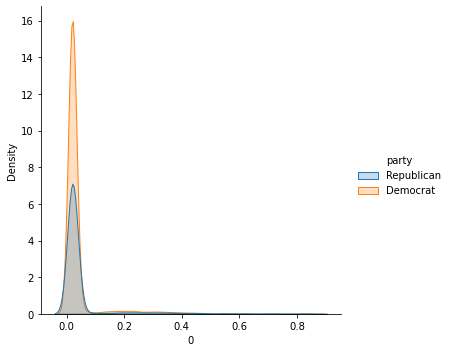

In [41]:
# Visualization- Topic 0 - for party 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

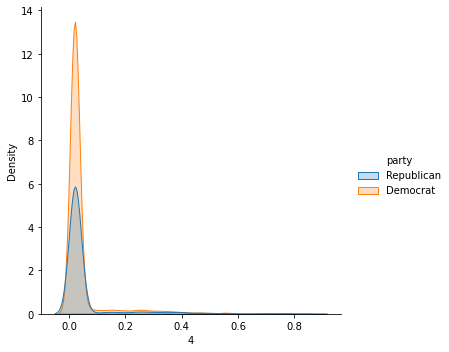

In [42]:
# Visualization- Topic 4 - for party 
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## For both topics 0 and 4, it appears that Republicans discuss them more than Democrats. Looking at the words in each topic above, topic 0 seems to discuss help surrounding COVID-19 and topic 4 mentions Trump, realdonaldtrump, (his twitter handle), and impeachment several times. The latter makes sense as a Republican topic. 

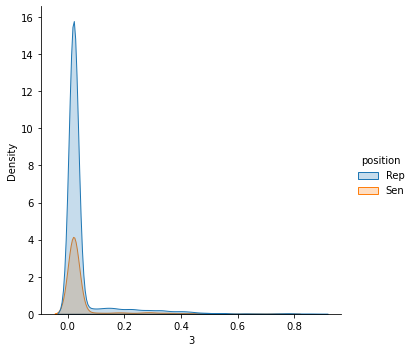

In [43]:
# Visualization- Topic 3 - for position
sns.displot(df_w_topics, x=df_w_topics[3], hue = "position", kind = 'kde', fill = 'true')
plt.show()

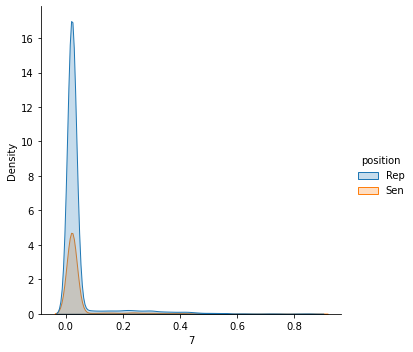

In [44]:
# Visualization- Topic 7 - for position
sns.displot(df_w_topics, x=df_w_topics[7], hue = "position", kind = 'kde', fill = 'true')
plt.show()

## For both topics 3 and 7, the visualizations show that representatives discuss them more heavily than senators, however looking at the words in each topic above does not help us understand the distinction. 

## Overall, the visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the party (Democrats/Republicans) or position(senate/representative). 

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

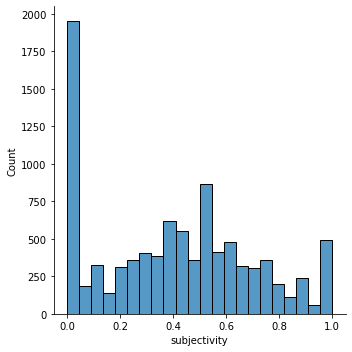

In [45]:
#check subjectivity for all tweets 
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

## Subjective sentences generally refer to personal opinion, emotion or judgment (=1) whereas objective refers to factual information (=0). Although the overall distribution is relatively normal, there is a much higher count of lower subjectivity tweets (0) compared to higher subjectivity tweets (1). 

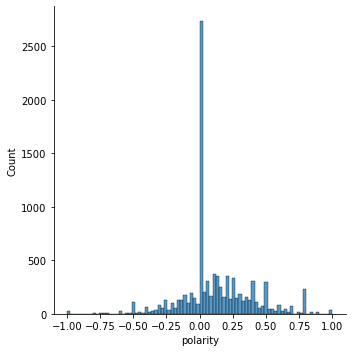

In [46]:
#check sentiment/polarity for all tweets 
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity")
plt.show()

## Polarity refers to sentiment with 1 meaning a positive sentiment and -1 meaning a negative sentiment and 0 meaning a neutral sentiment. The visualization demonstrates an overall neutral sentiment with more counts leaning towards positive sentiment. 

## 2) Choose two legislators, one liberal and one conservative

In [47]:
# get list of Republican tweets
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ..."
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson..."
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ..."


In [48]:
# select David Joyce
congress_tweets_DavidJoyce = congress_tweets[congress_tweets["name_wikipedia"]=="David Joyce"].copy()
congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",oh14 salutes patrolman st clair fox8news 5year...,0.00000,0.000000
2006,1.166760e+18,RepDaveJoyce,2019-08-28T13:29:18-04:00,"As the son of a wounded WWII vet, I applaud @P...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[son, wounded, wwii, vet, applaud, potus, deci...",son wounded wwii vet applaud potus decision ca...,0.15000,-0.100000
3105,1.161730e+18,RepDaveJoyce,2019-08-14T15:49:18-04:00,Always honored to speak at the annual 3chamber...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, speak, annual, 3chamber, luncheon, s...",honored speak annual 3chamber luncheon spoke 1...,0.25000,-0.125000
3508,1.304440e+18,RepDaveJoyce,2020-09-11T11:06:06-04:00,Godspeed Detective QT @wkyc A sea of police o...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[godspeed, detective, wkyc, sea, police, offic...",godspeed detective wkyc sea police officers le...,0.00000,0.000000
3928,1.268180e+18,RepDaveJoyce,2020-06-03T09:44:48-04:00,RT @AmChemMatters Ohio chemistry has stepped u...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[amchemmatters, ohio, chemistry, stepped, help...",amchemmatters ohio chemistry stepped help loca...,0.00000,0.000000
4410,1.316030e+18,RepDaveJoyce,2020-10-13T11:10:07-04:00,Looking forward to visiting this local manufac...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[looking, forward, visiting, local, manufactur...",looking forward visiting local manufacturer th...,0.27500,0.233333
4689,1.214590e+18,RepDaveJoyce,2020-01-07T11:56:51-05:00,"Good luck in your 2020 seasons, Cardinals! #c...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[good, luck, 2020, seasons, cardinals, cardsco...",good luck 2020 seasons cardinals cardscompete ...,0.60000,0.700000
6493,1.189640e+18,RepDaveJoyce,2019-10-30T16:34:52-04:00,Always honored and humbled to join @the_USO in...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[honored, humbled, join, theuso, assembling, c...",honored humbled join theuso assembling care pa...,0.00000,0.000000
6650,1.149330e+18,RepDaveJoyce,2019-07-11T10:58:15-04:00,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[energycommerce, hr, 728, title, viii, nursing...",energycommerce hr 728 title viii nursing workf...,0.00000,0.000000
7461,1.288510e+18,RepDaveJoyce,2020-07-29T12:09:48-04:00,Great news for NEOH and the entire Buckeye Sta...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[great, news, neoh, entire, buckeye, state, us...",great news neoh entire buckeye state usdot fun...,0.58125,0.450000


In [49]:
#average subjectivity for David Joyce tweets
congress_tweets_DavidJoyce_meanS = congress_tweets_DavidJoyce["subjectivity"].mean()
print(congress_tweets_DavidJoyce_meanS)

0.23509615384615387


In [50]:
#average polarity for David Joyce tweets
congress_tweets_DavidJoyce_meanP = congress_tweets_DavidJoyce["polarity"].mean()
print(congress_tweets_DavidJoyce_meanP)

0.1455128205128205


## The overall subjectivity score for David Joyce(Republican) is 0.24 and the overall polarity score is 0.15 


In [51]:
# get list of Democrat tweets
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da..."
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp..."


In [52]:
# select Josh Harder
congress_tweets_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
congress_tweets_JoshHarder

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",case missed bipartisanship works bill eradicat...,0.000000,0.000000
173,1.275220e+18,RepJoshHarder,2020-06-22T20:00:00-04:00,Big thanks to the @USChamber for giving me the...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[big, thanks, uschamber, giving, spirit, enter...",big thanks uschamber giving spirit enterprise ...,0.366667,0.200000
856,1.333120e+18,RepJoshHarder,2020-11-29T14:00:01-05:00,Folks – tomorrow Congress is back in session –...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[folks, tomorrow, congress, session, blown, aw...",folks tomorrow congress session blown away sti...,0.000000,0.000000
1042,1.117520e+18,RepJoshHarder,2019-04-14T16:00:00-04:00,Wishing our Sikh neighbors and friends a happy...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[wishing, sikh, neighbors, friends, happy, vai...",wishing sikh neighbors friends happy vaisakhi,1.000000,0.800000
1636,1.328760e+18,RepJoshHarder,2020-11-17T13:00:00-05:00,"Folks – get a FREE Covid test today (Tuesday, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[folks, free, covid, test, tuesday, nov, 17, t...",folks free covid test tuesday nov 17 turlock p...,0.613333,0.186667
1679,1.321630e+18,RepJoshHarder,2020-10-28T22:00:00-04:00,Farmworkers in the Valley literally feed the c...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[farmworkers, valley, literally, feed, country...",farmworkers valley literally feed country glad...,1.000000,0.500000
1925,1.312560e+18,RepJoshHarder,2020-10-03T21:00:00-04:00,Human trafficking is disgusting and we have to...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[human, trafficking, disgusting, stamp, safety...",human trafficking disgusting stamp safety pled...,0.662963,-0.166667
2375,1.118270e+18,RepJoshHarder,2019-04-16T17:35:00-04:00,Every week I call people who write my office. ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[week, people, write, office, heard, week]",week people write office heard week,0.000000,0.000000
3352,1.132750e+18,RepJoshHarder,2019-05-26T16:30:00-04:00,"We need the trade war to end, but until then, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[trade, war, end, support, farmers, help]",trade war end support farmers help,0.000000,0.000000
3477,1.226980e+18,RepJoshHarder,2020-02-10T16:11:14-05:00,Thanks Darleen. Our veterans sacrificed life a...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[thanks, darleen, veterans, sacrificed, life, ...",thanks darleen veterans sacrificed life limb b...,0.200000,0.200000


In [53]:
#average subjectivity for Josh Harder tweets
congress_tweets_JoshHarder_meanS = congress_tweets_JoshHarder["subjectivity"].mean()
print(congress_tweets_JoshHarder_meanS)

0.4465533540533541


In [54]:
#average polarity for Josh Harder tweets
congress_tweets_JoshHarder_meanP = congress_tweets_JoshHarder["polarity"].mean()
print(congress_tweets_JoshHarder_meanP)

0.20331002331002332


## The overall subjectivity score for Josh Harder (Democrat) is 0.46 and the overall polarity score is 0.21. Compared to David Joyce, Josh Harder has both a higher subjectivity (less objective) and higher polarity (more positive sentiment). 

## 3-1)  compare Democrats v. Republicans 

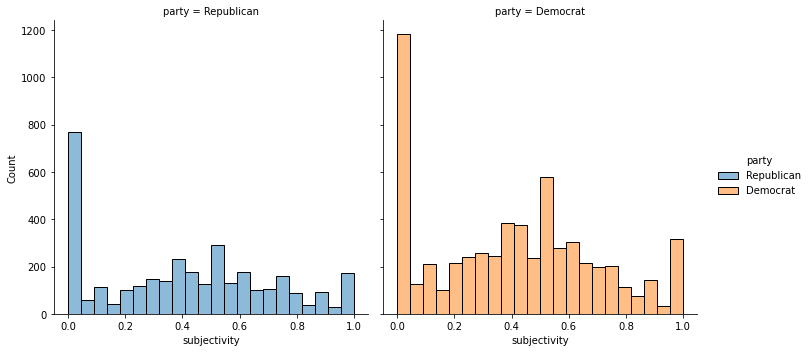

In [55]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

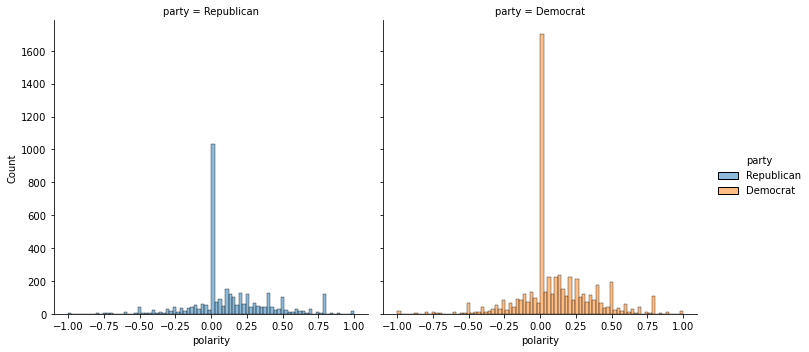

In [56]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

## Overall, Democrats (party 0) have higher neutral subjectivity (=0) and higher neutral sentiment (polarity =0) than Republicans (party 1) meaning that the tweets they post are more objective and neutral.

## 3-2) compare Senators v. Representatives 

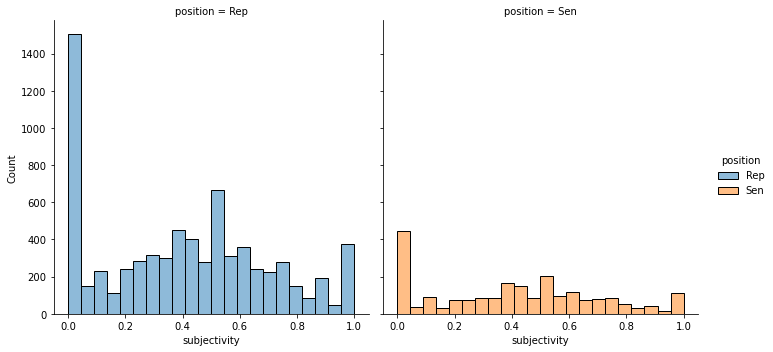

In [57]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

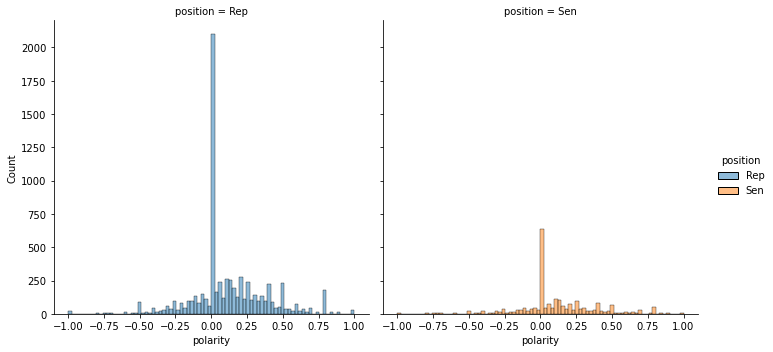

In [58]:
sns.displot(congress_tweets, x="polarity", hue = 'position', col = 'position')
plt.show()

## Overall, representatives (position 0) have higher neutral subjectivity (=0) and higher neutral sentiment (polarity = 0) than senators (position 1) meaning that the tweets they post are more objective and neutral in sentiment. 

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [59]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_str', 'subjectivity',
       'polarity'],
      dtype='object')

### Engineered Text Features

In [60]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))


In [61]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,5,6,7,8,9,polarity,subjectivity
0,0.021456,0.021456,0.021457,0.021456,0.021456,0.021456,0.644461,0.021456,0.183888,0.021457,0.000000,0.0
1,0.025534,0.025534,0.025534,0.025534,0.025536,0.125947,0.025536,0.025534,0.669774,0.025535,0.000000,0.0
2,0.029562,0.029562,0.029563,0.029563,0.243635,0.029562,0.029562,0.519788,0.029635,0.029567,0.800000,1.0
3,0.023078,0.023078,0.023078,0.023078,0.023078,0.023078,0.023078,0.222544,0.592830,0.023078,0.000000,0.0
4,0.018231,0.018232,0.018233,0.018241,0.018231,0.018233,0.018232,0.120307,0.733822,0.018238,-0.166667,1.0


### Bag-of-words or Tf-idf

In [62]:
# Frequency Based featurization
X = congress_tweets['tokens_str']
tf = TfidfVectorizer()

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [63]:
tfidf_df.head()

,03,08232020,082419,0amazon,0coors,0gm,0we,10,100,1000,...,zuckbuck,zuckerberg,zulfikar,zurfluh,ángeles,áreas,ōlelo,תודה,مبارک,نوروز
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X.head(30)

0     oh14 salutes patrolman st clair fox8news 5year...
1     case missed bipartisanship works bill eradicat...
2      wishing happy passover celebrating seder tonight
3     whitehouse president realdonaldtrump signed bi...
4     sent letter demanding administration stop play...
5     president attacks rep ilhan dishonest dangerou...
6     housegop time holding china accountable china ...
7     wdtnews confirmed covid19 cases jefferson coun...
8     svleadershipgrp game changers accept responsib...
9     nation remain land free long home brave ” elme...
10    true address soon thehill charitable giving am...
11    preach shondarhimes homeschooling 6year old 8y...
12    public institutions asu nation student fulbrig...
13    way eric swalwell continue serve house intelli...
14    air sethleibsohn talk todays developments impe...
15    whistleblower reportedly worked joe biden ukra...
16    montclairnjgov essex county satellite testing ...
17    know lot concern food supply chain bay are

### Word Embedding - N STOPPED HERE 

In [65]:
#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [66]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_str,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",oh14 salutes patrolman st clair fox8news 5year...,0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",case missed bipartisanship works bill eradicat...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",wishing happy passover celebrating seder tonight,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",whitehouse president realdonaldtrump signed bi...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",sent letter demanding administration stop play...,1.0,-0.166667


In [67]:
#see length of first token
len(congress_tweets['tokens'][0])

14

In [68]:
#see length of first doc
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

6

In [69]:
doc [0:5]

['st', 'battling', 'cancer', 'police', 'officer']

In [70]:
#grab the first vector for each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.12629223

In [71]:
#Define a function to average word embeddings for a document
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [72]:
# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
index_num = 0 # identify docs we can't get vector for
empty_docs = []
for doc in congress_tweets['tokens']: # append the vector for each document
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc)<1:
        empty_docs.append(index_num) # collect index for docs we can't get vector for -- used later in classification
        continue
    empty_list_embeddings_means.append(document_vector(model, doc))
    index_num += 1
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [73]:
#average embeddings for each document 
doc_average_embeddings

array([[-0.12629223,  0.289198  ,  0.10509451, ..., -0.27233744,
         0.15626346, -0.00847813],
       [-0.07734222,  0.25574005,  0.0956725 , ..., -0.23886018,
         0.13564083,  0.01069972],
       [-0.11119966,  0.28291664,  0.10663603, ..., -0.26827106,
         0.16488536, -0.000636  ],
       ...,
       [-0.10991319,  0.25039554,  0.09640407, ..., -0.23742835,
         0.13517277, -0.00874468],
       [-0.15923743,  0.37379533,  0.12486295, ..., -0.34331596,
         0.19557291, -0.00918905],
       [-0.14485428,  0.3607936 ,  0.12773702, ..., -0.3392085 ,
         0.19581878, -0.01973069]], dtype=float32)

In [74]:
#check the shape of the average document embeddings 
doc_average_embeddings.shape

(9398, 100)

In [75]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 
word2vec_features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.126292,0.289198,0.105095,-0.049639,0.105833,-0.374391,0.069087,0.551400,-0.161434,-0.121413,...,0.347941,0.077115,0.056761,0.024986,0.352929,0.227708,0.112464,-0.272337,0.156263,-0.008478
1,-0.077342,0.255740,0.095673,-0.046122,0.078966,-0.343046,0.043453,0.480108,-0.157108,-0.109276,...,0.299014,0.083533,0.034746,0.009522,0.279864,0.193663,0.079898,-0.238860,0.135641,0.010700
2,-0.111200,0.282917,0.106636,-0.047574,0.097881,-0.362021,0.065864,0.554106,-0.154940,-0.120786,...,0.347550,0.068114,0.064330,0.023940,0.353978,0.243242,0.101577,-0.268271,0.164885,-0.000636
3,-0.155813,0.414726,0.159776,-0.066701,0.120347,-0.531232,0.085671,0.766610,-0.236184,-0.181615,...,0.460059,0.111356,0.060830,0.019507,0.464060,0.304669,0.137287,-0.390532,0.230393,0.004817
4,-0.136280,0.308599,0.107511,-0.046106,0.108271,-0.372582,0.074851,0.567573,-0.166984,-0.124162,...,0.362898,0.088185,0.052805,0.027775,0.362375,0.233940,0.126912,-0.287186,0.154982,-0.012590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,-0.141363,0.339049,0.120180,-0.059109,0.116046,-0.428021,0.079471,0.641839,-0.193182,-0.139392,...,0.408786,0.091539,0.064875,0.034500,0.406550,0.268895,0.132289,-0.318751,0.178417,-0.009760
9394,-0.166666,0.344954,0.114582,-0.051331,0.124253,-0.401498,0.085550,0.626644,-0.180210,-0.137126,...,0.417380,0.103977,0.057881,0.039374,0.407214,0.264218,0.150703,-0.313019,0.164843,-0.021113
9395,-0.109913,0.250396,0.096404,-0.044095,0.085300,-0.319797,0.057787,0.465775,-0.138793,-0.107210,...,0.292140,0.075042,0.042968,0.010869,0.303894,0.196206,0.095700,-0.237428,0.135173,-0.008745
9396,-0.159237,0.373795,0.124863,-0.064930,0.131443,-0.473969,0.083079,0.709142,-0.204058,-0.149541,...,0.457666,0.115594,0.075381,0.050670,0.447690,0.304049,0.152006,-0.343316,0.195573,-0.009189


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [76]:
# collect the labels for party and chamber membership

lb_style = LabelBinarizer()
y_party = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])
    #0=Democrat and 1=Republican
y_chamber = congress_tweets['position'] =lb_style.fit_transform(congress_tweets['position'])
    #0=House of Rep and 1=Senate

### 1. Engineered features

#### 1.1 classify party

In [77]:
# split the data into training and test sets
X_ef_p_train, X_ef_p_test, y_p_train, y_p_test = train_test_split(engineered_features_with_topics,
                                                                  y_party,
                                                                  stratify=y_party,
                                                                  train_size = 0.80,
                                                                  test_size= 0.20,
                                                                  random_state = 10)

In [78]:
# sanity check
print(X_ef_p_train.shape)
print(y_p_train.shape)
print(X_ef_p_test.shape)
print(y_p_test.shape)

(7545, 12)
(7545, 1)
(1887, 12)
(1887, 1)


In [79]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_ef_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


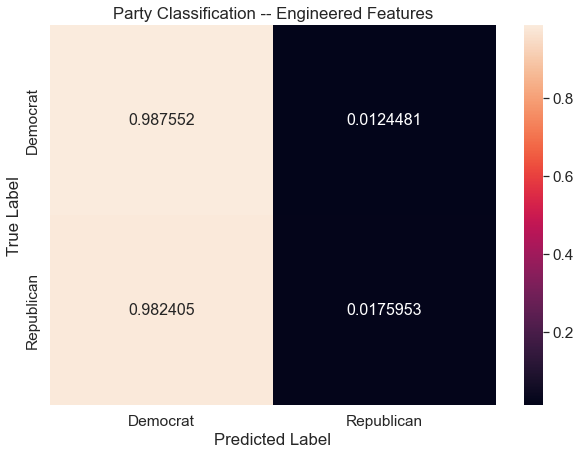

In [80]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [81]:
#EG: The model is not giving us great pedictions. I think it has to do with the fact that we used the topics
# for only the House of Rep in the engineered_features_with_topics. We'll have to fix that to test the model again.
#NE: the model is still not giving a great prediction for republicans... 

#### 1.2 classify chamber

In [82]:
# split the data into training and test sets
X_ef_c_train, X_ef_c_test, y_c_train, y_c_test = train_test_split(engineered_features_with_topics,
                                                                  y_chamber,
                                                                  stratify=y_chamber,
                                                                  train_size = 0.80,
                                                                  test_size=0.20,
                                                                  random_state = 10)

In [83]:
# sanity check
print(X_ef_c_train.shape)
print(y_c_train.shape)
print(X_ef_c_test.shape)
print(y_c_test.shape)

(7545, 12)
(7545, 1)
(1887, 12)
(1887, 1)


In [84]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_ef_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/Users/ernesto/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


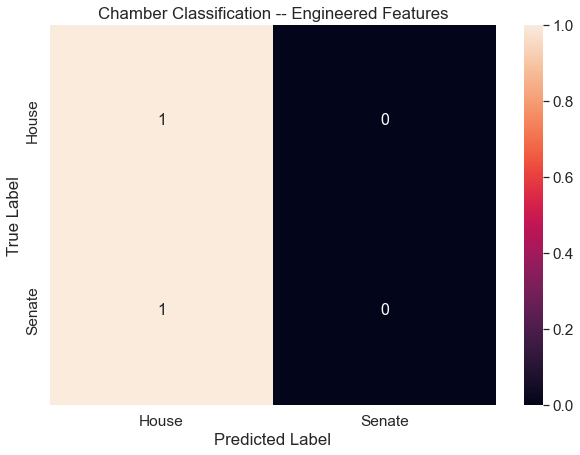

In [85]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [86]:
#EG: this Logistic model works great, but this is only because the df only contains topics related to House of Rep.
# so the data was biased since the beginning.
#NE: this is also showing a terrible prediction 

### 2. tf-idf

#### 2.1 classify party

In [87]:
# split the data into training and test sets
X_tfidf_p_train, X_tfidf_p_test, y_p_train, y_p_test = train_test_split(tfidf_df,
                                                                        y_party,
                                                                        stratify=y_party,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [88]:
# sanity check
print(X_tfidf_p_train.shape)
print(y_p_train.shape)
print(X_tfidf_p_test.shape)
print(y_p_test.shape)

(7545, 27673)
(7545, 1)
(1887, 27673)
(1887, 1)


In [89]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_tfidf_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_tfidf_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

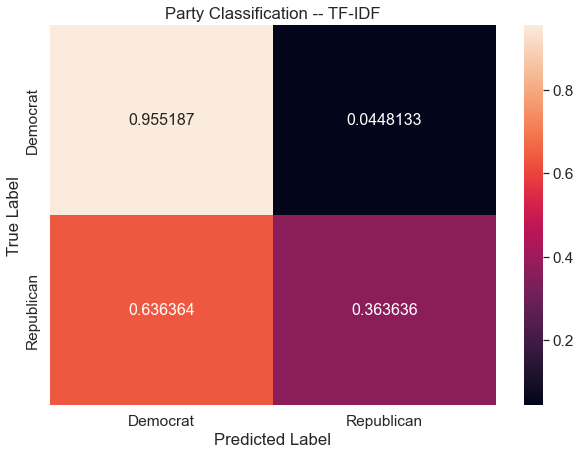

In [90]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 2.2 classify chamber

In [91]:
# split the data into training and test sets
X_tfidf_c_train, X_tfidf_c_test, y_c_train, y_c_test = train_test_split(tfidf_df,
                                                                        y_chamber,
                                                                        stratify=y_chamber,
                                                                        train_size = 0.80,
                                                                        test_size=0.20,
                                                                        random_state = 10)

In [92]:
# sanity check
print(X_tfidf_c_train.shape)
print(y_c_train.shape)
print(X_tfidf_c_test.shape)
print(y_c_test.shape)

(7545, 27673)
(7545, 1)
(1887, 27673)
(1887, 1)


In [93]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_tfidf_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_tfidf_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

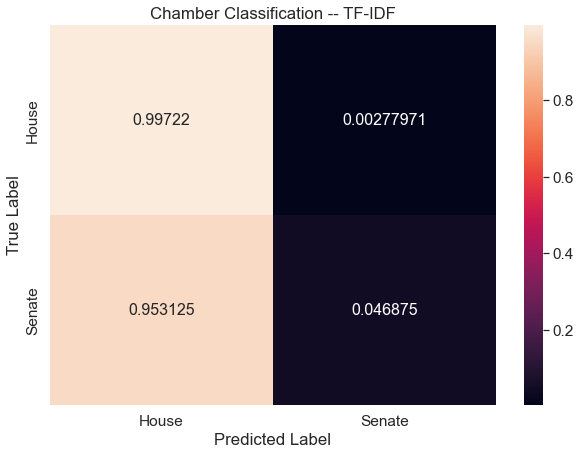

In [94]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [95]:
#EG: in general, tf-idf is better for Hourse of Rep than senate. 
# I'm not sure why. Ideas? NE: because of the data imbalance? More reps than senators? 

### 3. Embeddings

In [96]:
# adjust length of labels y (for party and chamber) to match embedding length

print("Lenth of embeddings:",len(doc_average_embeddings))
print()

#party
emb_y_party = np.delete(y_party, empty_docs, axis=0)
print("Lenth of party labels:",len(emb_y_party))

#chamber
emb_y_chamber = np.delete(y_chamber, empty_docs, axis=0)
print("Lenth of chamber labels:",len(emb_y_chamber))

Lenth of embeddings: 9398

Lenth of party labels: 9398
Lenth of chamber labels: 9398


#### 3.1 classify party

In [97]:
X_emb_p_train, X_emb_p_test, y_p_train, y_p_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_party,
                                                                    stratify=emb_y_party,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [98]:
# sanity check
print(X_emb_p_train.shape)
print(y_p_train.shape)
print(X_emb_p_test.shape)
print(y_p_test.shape)

(7518, 100)
(7518, 1)
(1880, 100)
(1880, 1)


In [99]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_emb_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_emb_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

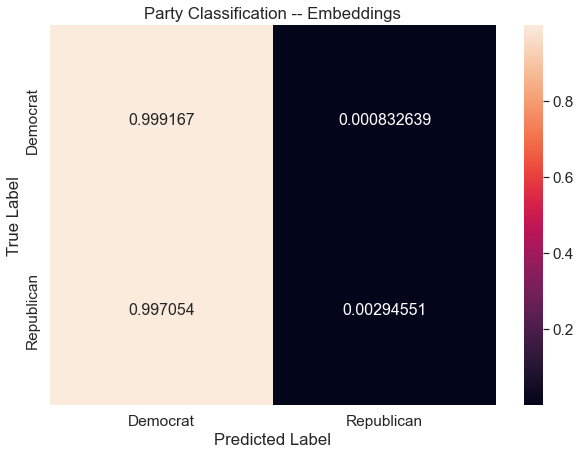

In [100]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 3.2 classify chamber

In [101]:
X_emb_c_train, X_emb_c_test, y_c_train, y_c_test = train_test_split(doc_average_embeddings,
                                                                    emb_y_chamber,
                                                                    stratify=emb_y_chamber,
                                                                    train_size = 0.80,
                                                                    test_size=0.20,
                                                                    random_state = 10)

In [102]:
# sanity check
print(X_emb_c_train.shape)
print(y_c_train.shape)
print(X_emb_c_test.shape)
print(y_c_test.shape)

(7518, 100)
(7518, 1)
(1880, 100)
(1880, 1)


In [103]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_emb_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_emb_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

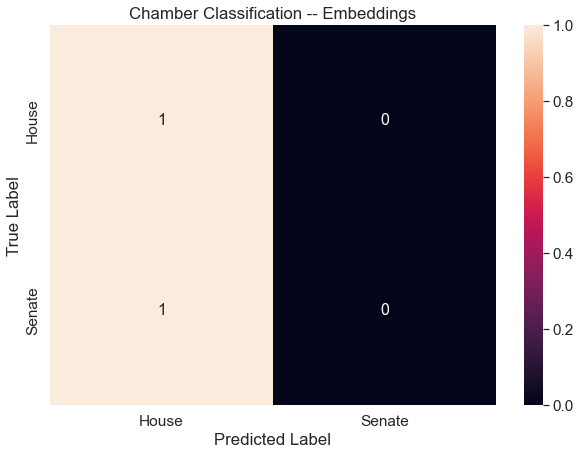

In [104]:
# display confusion matrix

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Embeddings")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [105]:
#EG: I don't understand why the embedding model is giving us such bad predictions for party and chamber.
# Any thoughts? Maybe you two can see something I can't.

### Two Combined Models

In [106]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**